Recurrent Neural Network

In [1]:
# IMPORTING THE LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [2]:
# MOUNTING GOOGLE DRIVE TO LOAD AND STORE THE DATA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# PARAMETER FOR STFT
SAMPLING_RATE=16000
DURATION=10
N_FFT = 1024
WIN_LENGTH = 1024
HOP_LENGTH = 512

In [4]:
# LOADING THE TRAINING SPECTROGRAMS
X = np.load('/content/drive/MyDrive/val_set/Final_Dataset/training_spectrogram.npy')
print(X.shape)
y = np.load('/content/drive/MyDrive/val_set/Final_Dataset/training_labels.npy')
print(y.shape)
from sklearn.utils import shuffle
X, y = shuffle(X, y)

(717, 513, 313)
(717,)


In [5]:
# EXTRACTING THE MFCC FEATURES FROM THE SPECTROGRAM
def get_mfcc(X):
  X_new = []
  for i in range(len(X)):
    mel_spectrogram = librosa.feature.melspectrogram(S=X[i], n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc = librosa.feature.mfcc(S=mel_spectrogram, sr=16000,n_mfcc=20)
    mean = np.average(mfcc)
    std = np.std(mfcc)
    if(std == 0):
      std = std + 1e-25
    mfcc = (mfcc - mean)/std
    X_new.append(mfcc)
  return np.array(X_new)
X = get_mfcc(X)

In [6]:
# FUNCTIONS TO CONVERT STRING TO ONE-HOT-VECTORS
def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])

def string2ohv(y):
  y_ohv = []
  for i in y:
    y_ohv.append(one_hot_enc(i))
  return np.array(y_ohv)

In [7]:
# SPLITTING DATA BETWEEN TRAINING AND TESTING. 
# The test split is used for validation during the training purpose and the final test is performed on the recieved data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(573, 20, 313)
(144, 20, 313)


In [8]:
# RESHAPING THE DATA
def reshape(X, y):
  # Reshape the data to make each entry in the spectrogram a training sample
  X_new = []
  y_new = []
  for i in range(len(X)):
    X_new.append(np.transpose(X[i]))
    # print(X[i].shape[1])
    y_new.append([y[i]]*X[i].shape[1])
    # print(np.shape(y_new))
  X_new = np.array(X_new)
  y_new = np.array(y_new)
  X_new = X_new.reshape((-1, X[0].shape[0]))
  y_new = y_new.reshape((-1, 1))
  print(X_new.shape)
  print(y_new.shape)
  return X_new, y_new
X_train, y_train = reshape(X_train, y_train)
X_test, y_test = reshape(X_test, y_test)
y_test = string2ohv(y_test)
y_train = string2ohv(y_train)
print(y_train.shape)
print(y_test.shape)

(179349, 20)
(179349, 1)
(45072, 20)
(45072, 1)
(179349, 3)
(45072, 3)


In [9]:
# PREPARING THE BAG OF FRAMES TO ESTABLISH TEMPORAL DEPENDENCE
def make_bags(X_prev):
  X_new = []
  X_new.append(X_prev[:7])
  X_new.append(X_prev[:7])
  X_new.append(X_prev[:7])

  for i in tqdm(range(len(X_prev)-6)):
    A = X_prev[i:i+7]
    X_new.append(A)

  X_new.append(X_prev[-7:])
  X_new.append(X_prev[-7:])
  X_new.append(X_prev[-7:])
  
  X_new = np.array(X_new)
  return X_new
X_test_reshaped = make_bags(X_test)
print(X_test_reshaped.shape)
X_train_reshaped = make_bags(X_train)
print(X_train_reshaped.shape)

100%|██████████| 45066/45066 [00:00<00:00, 1100722.69it/s]


(45072, 7, 20)


100%|██████████| 179343/179343 [00:00<00:00, 1299849.60it/s]


(179349, 7, 20)


In [10]:
# BUILDING THE MODEL 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, TimeDistributed, LSTM
def get_rec_model():
  # the shape of the data needs to be (n, time, features)
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(64, activation='relu')))
  model.add(TimeDistributed(Dense(32, activation='relu')))
  model.add(TimeDistributed(Dense(16, activation='relu')))
  model.add(TimeDistributed(Dense(8, activation='relu')))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', metrics=['accuracy'])
  return model

In [12]:
# CHECKPOINTS FOR SAVING THE MODEL WEIGHTS AT EACH EPOCH
checkpoint_path = "/content/drive/MyDrive/val_set/models/RNN_FINAL_Normalized_MFCC.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
os.listdir(checkpoint_dir)

['CNN_FINAL',
 'CNN_FINAL.ckpt.index',
 'CNN_FINAL.ckpt.data-00000-of-00001',
 'CNN_FINAL_Normalized.ckpt.index',
 'CNN_FINAL_Normalized.ckpt.data-00000-of-00001',
 'CNN_FINAL_MFCC',
 'CNN_FINAL_MFCC_NORMALIZED',
 'CNN_FINAL_MFCC_CORRECT',
 'CNN_FINAL_Normalized_MFCC.ckpt.index',
 'checkpoint',
 'CNN_FINAL_Normalized_MFCC.ckpt.data-00000-of-00001']

In [16]:
# TRAINING AND SAVING THE MODEL
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = get_rec_model()
history = model.fit(X_train_reshaped, y_train, epochs=15, batch_size=64, shuffle=True, validation_data=(X_test_reshaped, y_test), callbacks=[cp_callback])
model.save('/content/drive/MyDrive/val_set/models/RNN_FINAL_MFCC_CORRECT')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 128)            76288     
                                                                 
 lstm_2 (LSTM)               (None, 7, 128)            131584    
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 time_distributed (TimeDistr  (None, 7, 64)            8256      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 32)            2080      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 7, 16)           

INFO:tensorflow:Assets written to: /content/drive/MyDrive/val_set/models/RNN_FINAL_MFCC_CORRECT/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/val_set/models/RNN_FINAL_MFCC_CORRECT/assets


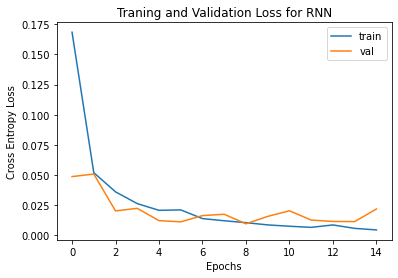

In [17]:
plt.title('Traning and Validation Loss for RNN')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(np.arange(15),history.history.get('loss', []), label='train')
plt.plot(np.arange(15),history.history.get('val_loss', []), label='val')
plt.legend()
plt.show()

In [ ]:
# LOADING THE PREVIOUS TRAINED MODEL

latest = tf.train.latest_checkpoint(checkpoint_dir)
# Create a new model instance
model = get_conv_model()

# Load the previously saved weights
model.load_weights(latest)


In [ ]:
test_spectrograms = os.listdir('/content/drive/MyDrive/val_set/mock_spectrograms')
print(test_spectrograms)
X_test_mock = []
for i in range(len(test_spectrograms)):
  temp = np.load('/content/drive/MyDrive/val_set/mock_spectrograms/'+test_spectrograms[i])
  X_test_mock.append(temp)
X_test_mock = np.array(X_test_mock)
print(X_test_mock.shape)
X_mock_mfcc = get_mfcc(X_test_mock)
print(X_mock_mfcc.shape)

['test_sample-9.npy', 'test_sample-3.npy', 'test_sample-1.npy', 'test_sample-2.npy', 'test_sample-5.npy', 'test_sample-8.npy', 'test_sample-0.npy', 'test_sample-6.npy', 'test_sample-4.npy', 'test_sample-7.npy']
(10, 513, 313)
(10, 20, 313)


In [ ]:
# RESHAPING THE TEST DATA
def reshape_test(X):
  # Reshape the data 
  X_new = []
  for i in range(len(X)):
    X_new.append(np.transpose(X[i]))
    # print(X[i].shape[1])
    # print(np.shape(y_new))
  X_new = np.array(X_new)
  X_new = X_new.reshape((-1, X[0].shape[0]))
  print(X_new.shape)
  return X_new

In [ ]:
def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex256))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

In [25]:
demo = np.load('/content/demo2.npy')
mel_spectrogram = librosa.feature.melspectrogram(S=demo, n_fft=N_FFT, hop_length=HOP_LENGTH)
mfcc = librosa.feature.mfcc(S=mel_spectrogram, sr=16000,n_mfcc=20)
mean = np.average(mfcc)
std = np.std(mfcc)
if(std == 0):
  std = std + 1e-25
mfcc = (mfcc - mean)/std

In [26]:
X_mock_mfcc_reshaped = np.transpose(mfcc)
print(X_mock_mfcc_reshaped.shape)
mock2 = make_bags(X_mock_mfcc_reshaped)
print(mock2.shape)

(313, 20)


100%|██████████| 307/307 [00:00<00:00, 506550.48it/s]

(313, 7, 20)


In [27]:
# MAKING PREDICTIONS
predictions = model.predict(mock2)
print(predictions)
new_predictions = []
for i in range(len(predictions)):
    if(predictions[i][0]>0.5):
      new_predictions.append('speech')
    elif(predictions[i][1]>0.5):
      new_predictions.append('music')
    else:
      new_predictions.append('silence')
print(new_predictions)

[[3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [9.84838419e-03 9.89877045e-01 2.74539489e-04]
 [1.24122687e-02 9.87408161e-01 1.79593029e-04]
 [1.63460504e-02 9.83519137e-01 1.34801099e-04]
 [7.08789685e-06 9.99992847e-01 1.38196455e-07]
 [2.46308723e-10 1.00000000e+00 1.51533002e-13]
 [4.21397611e-10 1.00000000e+00 6.36015221e-14]
 [5.16777836e-11 1.00000000e+00 2.36753819e-15]
 [5.22030119e-12 1.00000000e+00 1.70230925e-16]
 [3.11385778e-11 1.00000000e+00 4.78704641e-16]
 [3.86299241e-08 1.00000000e+00 4.17052157e-12]
 [5.25181036e-08 1.00000000e+00 3.52649888e-11]
 [1.06802887e-08 1.00000000e+00 3.90773941e-11]
 [2.50511984e-08 1.00000000e+00 6.65962355e-11]
 [1.48317882e-08 1.00000000e+00 7.83699286e-11]
 [3.32775960e-11 1.00000000e+00 1.29356947e-13]
 [3.52567650e-12 1.00000000e+00 1.45355380e-16]
 [1.39176553e-13 1.00000000e+00 2.694273

In [28]:
print(predictions)

[[3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [3.88437696e-02 9.60800409e-01 3.55834141e-04]
 [9.84838419e-03 9.89877045e-01 2.74539489e-04]
 [1.24122687e-02 9.87408161e-01 1.79593029e-04]
 [1.63460504e-02 9.83519137e-01 1.34801099e-04]
 [7.08789685e-06 9.99992847e-01 1.38196455e-07]
 [2.46308723e-10 1.00000000e+00 1.51533002e-13]
 [4.21397611e-10 1.00000000e+00 6.36015221e-14]
 [5.16777836e-11 1.00000000e+00 2.36753819e-15]
 [5.22030119e-12 1.00000000e+00 1.70230925e-16]
 [3.11385778e-11 1.00000000e+00 4.78704641e-16]
 [3.86299241e-08 1.00000000e+00 4.17052157e-12]
 [5.25181036e-08 1.00000000e+00 3.52649888e-11]
 [1.06802887e-08 1.00000000e+00 3.90773941e-11]
 [2.50511984e-08 1.00000000e+00 6.65962355e-11]
 [1.48317882e-08 1.00000000e+00 7.83699286e-11]
 [3.32775960e-11 1.00000000e+00 1.29356947e-13]
 [3.52567650e-12 1.00000000e+00 1.45355380e-16]
 [1.39176553e-13 1.00000000e+00 2.694273

In [29]:
new_predictions = []
for i in range(len(predictions)):
    if(predictions[i][0]>0.5):
      new_predictions.append('speech')
    elif(predictions[i][1]>0.5):
      new_predictions.append('music')
    else:
      new_predictions.append('silence')

In [30]:
print(new_predictions)

['music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'speech', 'speech', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'speech', 'speech', 'speech', 'speech', 'speech', 'music', 'speech', 'speech', 'music', 'music', 'music', 'speech', 'music', 'music', 'speech', 'speech', 'speech', 'speech', 'speech', 'speech', 'silence', 'music', 'music', 'music', 'music', 'music', 'silence', 'silence', 'silence', 'silence', 'silence', 'silence

In [31]:
# CONVERTING FRAME INDEX TO TIME
def to_time(iteration, frame_size=WIN_LENGTH, rate=SAMPLING_RATE, hop_size=HOP_LENGTH, duration=DURATION):
  total_iterations = int(np.ceil((DURATION*SAMPLING_RATE)/(hop_size)))
  return (float(iteration)/float(total_iterations))*DURATION

In [35]:
# PERFORMING DILATION
def dilate(X, span=5):
  X_dilated = []
  for i in range(len(X)):
    count = {'silence':0, 'speech':0, 'music':0}
    for j in range(max(0, i-span), min(len(X), i+span)):
      count[X[j]] = count[X[j]] + 1
    keymax = max(zip(count.values(), count.keys()))[1]
    X_dilated.append(keymax)
  return X_dilated

In [36]:
# PERFORMING DECODING
def Decode(predicted, frame_size=WIN_LENGTH, sr=SAMPLING_RATE, min_event_duration=0.4):
  ans = []
  predicted = dilate(predicted)
  prevclass = 'silence'
  curclass = 'silence'
  start = 0
  end = 0

  for i in range(len(predicted)):
    curclass = predicted[i]
    if(curclass != prevclass):
        if(prevclass != 'silence'):
          ans.append((start, to_time(i), prevclass))
        # the prev class has ended
        prevclass = curclass
        # the start time of the current class is now
        start = to_time(i)
  if(curclass !='silence'):
    ans.append((start, to_time(len(predicted)), curclass))
  # Combining adjacent classes (Dilation)
  compressed_ans = []
  pc = ans[0]
  for i in range(len(ans)-1):  
    cc = ans[i]
    nc = ans[i+1]

    if(nc[2] != cc[2]):
      compressed_ans.append(pc)
      pc = nc
    else:
      if(nc[0] - pc[1] >= min_event_duration):
        compressed_ans.append(pc)
        pc=nc
      else:
        pc = (pc[0], nc[1], pc[2])
  compressed_ans.append(pc)    
  
  final_ans = []
  # Erosion
  for i in range(len(compressed_ans)):
    if(compressed_ans[i][1] - compressed_ans[i][0] > min_event_duration):
      final_ans.append(compressed_ans[i])
  return final_ans

In [37]:
# PRINTING RESULTS
ans = Decode(new_predictions)
print(ans)

[(0.0, 2.428115015974441, 'music'), (3.8977635782747604, 5.782747603833865, 'music'), (6.166134185303514, 6.5814696485623, 'music'), (7.156549520766773, 10.0, 'music')]
